In [31]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from sklearn.model_selection import StratifiedKFold
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
class DepthWiseConv2d(nn.Module):
    def __init__(self, in_channels, kernel_size, kernels_per_layer, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*kernels_per_layer, kernel_size=kernel_size, groups=in_channels, bias=bias, padding='same')
    def forward(self, x):
        return self.depthwise(x)

class PointWiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernels_per_layer=1, bias=False):
        super().__init__()
        self.pointwise = nn.Conv2d(in_channels=in_channels*kernels_per_layer, out_channels=out_channels,
                                   kernel_size=(1,1), bias=bias, padding="valid")

    def forward(self, x):
        return self.pointwise(x)

class MaxNormLayer(nn.Linear):
    def __init__(self, in_features, out_features, max_norm=1.0,):
        super(MaxNormLayer, self).__init__(in_features=in_features, out_features=out_features)
        self.max_norm = max_norm

    def forward(self, x):
        if self.max_norm is not None:
            with torch.no_grad():
                self.weight.data = torch.renorm(
                    self.weight.data, p=2, dim=0, maxnorm=self.max_norm
                )
        return super(MaxNormLayer, self).forward(x)

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, kernels_per_layer=1, bias=False):
        super().__init__()
        self.depthwise = DepthWiseConv2d(in_channels=in_channels, kernels_per_layer=kernels_per_layer, kernel_size=kernel_size, bias=bias)
        self.pointwise = PointWiseConv2d(in_channels=in_channels, out_channels=out_channels, kernels_per_layer=kernels_per_layer, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

possíveis melhorias:
1 - trocar batchnorm por layernorm
2 - aplicação de transformer

In [34]:
class EEGNET(nn.Module):
    def __init__(
        self,
        n_channels,
        n_times,
        n_classes,
        kernel_length=64,
        F1=8,
        D=2,
        F2=16,
        pool1_stride=4,
        pool2_stride=8,
        dropout_rate=0.5,
        norm_rate=0.25,
    ):
        super().__init__()
        #block 1
        self.conv2d = nn.Conv2d(in_channels=n_channels, out_channels=F1, kernel_size=(1, kernel_length), bias=False, padding='same')
        self.batchNorm = nn.BatchNorm2d(num_features=F1, momentum=0.01, eps=0.001, track_running_stats=False)
        self.depthWise = DepthWiseConv2d(in_channels=F1, kernel_size=(n_channels, 1), kernels_per_layer=D, bias=False) #equivalente a convolução depth wise
        #---------------------------------------------------------------------

        #block 2
        self.batchNorm2 = nn.BatchNorm2d(num_features=F1*D, momentum=0.01, eps=0.001, track_running_stats=False)
        self.elu1 = nn.ELU()
        self.avgPool2d = nn.AvgPool2d(kernel_size=(1, pool1_stride), stride=pool1_stride)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.separableConv2d = SeparableConv2d(in_channels=F1*D, kernel_size=(1, 16), out_channels=F2, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(num_features=F2, momentum=0.01, eps=0.001, track_running_stats=False)
        self.elu2 = nn.ELU()
        self.avgPool2d_2 = nn.AvgPool2d(kernel_size=(1, pool2_stride), stride=pool2_stride)
        self.dropout2 = nn.Dropout(dropout_rate)
        #---------------------------------------------------------------------

        #final block
        self.flatten = nn.Flatten()
        self.maxNormLayer = MaxNormLayer(in_features = F2 * ((((n_times - pool1_stride) // pool1_stride + 1) - pool2_stride) // pool2_stride + 1), out_features=n_classes, max_norm=norm_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, targets):
        out = x.view((x.shape[0], x.shape[1], 1, x.shape[2])) # channel, batch, time (conv_depth, C, B, T)
        out = self.conv2d(out) # (B, F1, F1//2, T)
        out = self.batchNorm(out) # (B, F1, F1//2, T)
        out = self.depthWise(out) # (B, F1*D, F1//2, T)
        out = self.batchNorm2(out) # (B, F1*D, F1//2, T)
        out = self.elu1(out) # (B, F1*D, F1//2, T)
        out = self.avgPool2d(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.dropout1(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.separableConv2d(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.batchNorm3(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.elu2(out) # (B, F1*D, max(1, F1//(2*pool1_stride)), max(1, T//(2*pool1_stride)))
        out = self.avgPool2d_2(out) # (B, F1*D, F1//(2*pool1_stride), T//F2)
        out = self.dropout2(out) # (B, F1*D, F1//(2*pool1_stride), T//F2)
        out = self.flatten(out) # (B, (F1*D) * (F1//(2*4)) * (T//F2) )
        out = self.maxNormLayer(out) # (B, n_classes)
        logits = self.softmax(out) # (B, n_classes)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)


        return logits, loss



In [35]:
class TrainerTester:

    @staticmethod
    def train_loop(model, optimizer, X, y, batch_size=32, iterations=1000):
        lossi = []
        for k in range(iterations):
            batch_indexes = torch.randint(0, X.shape[0], (batch_size,))
            X_batch, y_batch = X[batch_indexes], y[batch_indexes] # batch X,Y
            pred, loss = model(X_batch, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if k % 100 == 0:
                print(f"loss: {loss} iteration: {k}/{iterations}")

            #tracking
            lossi.append(loss.item())

        return lossi

    @staticmethod
    def test_loop(model, Xtest, ytest):
        model.eval()
        X_batch, y_batch = Xtest, ytest

        with torch.no_grad():
            pred, loss = model(X_batch, y_batch)
            correct = (pred.argmax(1) == y_batch).type(torch.float32).sum().item() / y_batch.shape[0]

        print(f"Test loss: {loss:>8f} \n Accuracy: {correct:>8f} \n")
        model.train()

    @staticmethod
    def test_and_show(model, Xtest, ytest):
        model.eval()
        X_batch, y_batch = Xtest, ytest
        with torch.no_grad():
            pred, loss = model(X_batch, y_batch)
            print('shapes: ', pred.shape, y_batch.shape)
            accuracy = pred.argmax(1) == y_batch
            model.train()
            return accuracy

In [59]:
import mne
from moabb.datasets import BNCI2014001


class BciDataHandler:
    def __init__(self):
        self.data = BNCI2014001()
        self.subjects_epochs = {}
        self.subjects_labels = {}
        self.subjects_id = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.sessions_id = ['session_T', 'session_E']
        self.runs_id = ['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5']
        self.events_desc = {'left_hand': 1, 'right_hand': 2, 'both_feet': 3, 'tongue': 4}
        self.tmin, self.tmax, self.t_crop = -.5, 4.5, .5
        self.selected_events = ['left_hand', 'right_hand', 'both_feet', 'tongue']
        self.raw = self.data.get_data(subjects=self.subjects_id)
        self.picks = mne.pick_types(self.raw[1]['session_T']['run_0'].info, eeg=True, stim=False)

    def instantiate_dataset(self):
        for subject_id in self.subjects_id:
            print('subject_id: ', subject_id)
            epochs = []
            for session_id in self.sessions_id:
                print('session_id: ', session_id)
                for run_id in self.runs_id:
                    loop_raw = self.raw[subject_id][session_id][run_id]
                    events = mne.find_events(loop_raw, 'stim')
                    run_epochs = mne.Epochs(
                        loop_raw,
                        events,
                        self.events_desc,
                        picks=self.picks,
                        tmin=self.tmin,
                        tmax=self.tmax,
                        preload=True
                    )[self.selected_events]
                    epochs.append(run_epochs)

            self.subjects_epochs[subject_id] = (mne.concatenate_epochs(epochs)).filter(5, 60)
            self.subjects_labels[subject_id] = [event[2] for event in self.subjects_epochs[subject_id].events]


In [68]:
data_handler = BciDataHandler()

In [69]:
data_handler.instantiate_dataset()

subject_id:  1
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matchin

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  2
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    5.8s finished


Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
session_id:  session_E
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  3
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    7.4s finished


48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  4
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matchin

[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    5.6s finished


Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
session_id:  session_E
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: me

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  5
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    6.2s finished


Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
session_id:  session_E
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  6
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    6.3s finished


48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  7
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    6.3s finished


48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
session_id:  session_E
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  8
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    5.8s finished


0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
session_id:  session_E
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


subject_id:  9
session_id:  session_T
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata


[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    6.4s finished


48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
0 bad epochs dropped
48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 12672 out of 12672 | elapsed:    6.0s finished


In [70]:
model = EEGNET(n_channels=len(data_handler.picks), n_times=1251, n_classes=len(data_handler.selected_events))

In [71]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [72]:
data_handler.subjects_epochs

{1: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 MB, data loaded,
  'left_hand': 144
  'right_hand': 144
  'both_feet': 144
  'tongue': 144>,
 2: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 MB, data loaded,
  'left_hand': 144
  'right_hand': 144
  'both_feet': 144
  'tongue': 144>,
 3: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 MB, data loaded,
  'left_hand': 144
  'right_hand': 144
  'both_feet': 144
  'tongue': 144>,
 4: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 MB, data loaded,
  'left_hand': 144
  'right_hand': 144
  'both_feet': 144
  'tongue': 144>,
 5: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 MB, data loaded,
  'left_hand': 144
  'right_hand': 144
  'both_feet': 144
  'tongue': 144>,
 6: <EpochsArray |  576 events (all good), -0.5 - 4.5 sec, baseline -0.5 – 0 sec, ~121.0 M

In [83]:
seed = 1337
splits = 5

X = torch.tensor(data_handler.subjects_epochs[1].get_data()).to(dtype=torch.float32, device=device)
y = torch.tensor(data_handler.subjects_labels[1]).to(dtype=torch.long, device=device) - 1

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [84]:
#main-trianing-loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    TrainerTester.train_loop(model, optimizer, X_train, y_train)
    TrainerTester.test_loop(model, X_test, y_test)

loss: 1.2612115144729614 iteration: 0/1000


KeyboardInterrupt: 

Test loss: 1.242913 
 Accuracy: 0.465517 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.209394 
 Accuracy: 0.539130 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.196133 
 Accuracy: 0.547826 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.187888 
 Accuracy: 0.547826 

shapes:  torch.Size([50, 4]) torch.Size([50])
Test loss: 1.192442 
 Accuracy: 0.608696 

shapes:  torch.Size([50, 4]) torch.Size([50])


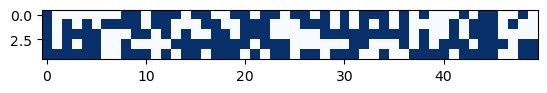

In [85]:
accuracy = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    TrainerTester.test_loop(model, X_test, y_test)
    accuracy.append(TrainerTester.test_and_show(model, X_test[:50], y_test[:50]).tolist())

plt.imshow(accuracy, cmap="Blues")

In [86]:
torch.save(model.state_dict(), 'model_states/model_states.txt')

In [40]:
model.load_state_dict(torch.load('model_states/model_states.txt'))

<All keys matched successfully>